<a href="https://colab.research.google.com/github/softn12/Signboard_detection/blob/main/python_code/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cpu
(482, 720, 3)


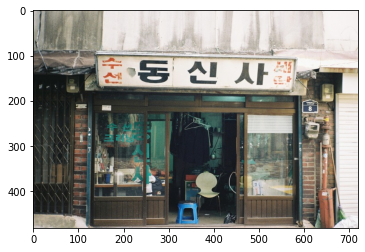

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)
  
#input image could be of any size
img0 = cv2.imread('sign1.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()


In [ ]:
# Object imformation : a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels
bbox0 = np.array([[90, 130, 190, 600], [300, 200, 400, 500]])
labels = np.array([1, 0]) #0 : background, 1: signboard

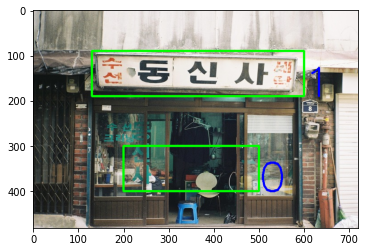

In [ ]:
# display bounding box and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
  cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3)
  cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)
plt.imshow(img0_clone)
plt.show()

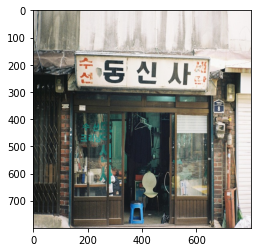

In [ ]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [ ]:
# change the bounding box coordinates
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0 :
  box = [int(a * b) for a, b in zip(box, ratioLst)]
  bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[149 144 315 666]
 [497 222 663 555]]


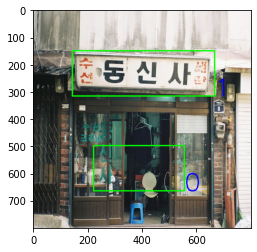

In [ ]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color = (0, 255, 0), thickness = 3) # Draw Rectangle
  cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness = 3) # Write the prediction
plt.imshow(img_clone)
plt.show()

In [ ]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained = True).to(device)
fe = list(model.features)
print(len(fe))

31


In [ ]:
# Collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1,3,800,800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
  k = i(k)
  if k.size()[2] < 800//16: #800/16=50:
    break
  req_features.append(i)
  out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) #512


torch.Size([1, 3, 800, 800])
30
512


In [ ]:
# Convert this list int a Sequential moudle
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) #Defing PyTorch Transform
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


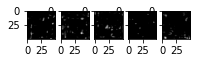

In [ ]:
# visualize the first 5 channels of the 50*50*512 features maps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(5):
  fig.add_subplot(1, 20, figNo)
  plt.imshow(imgArray[i], cmap='gray')
  figNo += 1
plt.show()

# Generate 22,500 anchor boxes on each input image

50x50=2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9=22,500

In [ ]:
# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
  for y in range(len(ctr_y)):
    ctr[index, 1] = ctr_x[x] - 8
    ctr[index, 0] = ctr_y[y] - 8
    index += 1
print(ctr.shape)

(2500, 2)


<function matplotlib.pyplot.show(*args, **kw)>

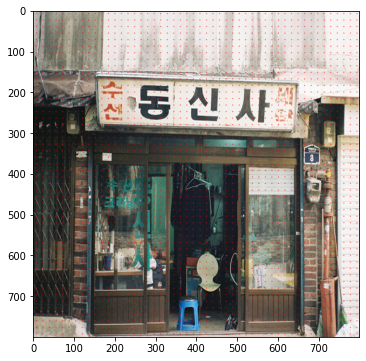

In [ ]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(ctr.shape[0]):
  cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255,0,0), thickness=1)
plt.imshow(img_clone)
plt.show

In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4)) #fe_size == 50
index = 0
for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(scales)):
      h = sub_sample * scales[j] * np.sqrt(ratios[i])
      w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
      anchor_boxes[index, 0] = ctr_y - h / 2.
      anchor_boxes[index, 1] = ctr_x - w / 2.
      anchor_boxes[index, 2] = ctr_y + h / 2.
      anchor_boxes[index, 3] = ctr_x + w / 2.
      index += 1
print(anchor_boxes.shape)

(22500, 4)


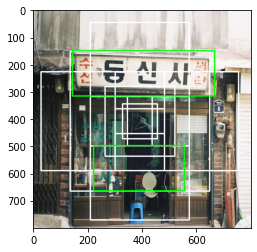

In [ ]:
# display the 9 anchor boxes of one anchor and the ground trugh bbox
img_clone = np.copy(img)
for i in range(11025, 11034):
  x0 = int(anchor_boxes[i][1])
  y0 = int(anchor_boxes[i][0])
  x1 = int(anchor_boxes[i][3])
  y1 = int(anchor_boxes[i][2])
  cv2.rectangle(img_clone, (x0, y0), (x1, y1), color = (255, 255, 2550), thickness=3)

for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color = (0, 255, 0), thickness = 3) # Draw Rectangle

plt.imshow(img_clone)
plt.show()

In [ ]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1) > 0 and (y2, x2) <= 800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
)[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [ ]:
# Calculate iou of the valid anchor boxes
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8940, 2) as the output.
ious = np.empty((len(valid_anchor_boxes), 2), dtype = np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)
  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])
    if(inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = iter_area / (anchor_area + box_area - iter_area)
    else:
      iou = 0.
      ious[num1, num2] = iou
print(ious.shape)


                

(8940, 2)


In [ ]:
# What anchor box has max iou with the ground truth box
gt_argmax_ious = ious.argmax(axis = 0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[0 0]
[0. 0.]
[   0    0    1 ... 8938 8939 8939]


In [ ]:
# What Ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis = 1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
